In [ ]:
# 1.1 - Exploración inicial de los datos (EDA)
# Se identifican valores nulos, atípicos y datos faltantes en las columnas relevantes.

import pandas as pd  # Manejo de datos
import numpy as np  # Cálculos numéricos
import matplotlib.pyplot as plt  # Gráficos básicos
import seaborn as sns  # Visualización avanzada
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Configuración para ver todas las columnas en la salida
pd.set_option('display.max_columns', None)

In [ ]:
## Fase 1: Exploración y Limpieza

In [ ]:
# 1.2 - Carga de datos en DataFrames
# Se cargan los datasets en dataframes para su análisis
try:
    df_flights = pd.read_csv("Customer Flight Activity.csv")
    df_customers = pd.read_csv("Customer Loyalty History.csv")
    print("Datos cargados correctamente.")
except FileNotFoundError:
    print("Error: No se encontraron los archivos.")

# Verificamos las primeras filas de cada dataset
print("\nPrimeras filas de df_flights:")
display(df_flights.head())

print("\nPrimeras filas de df_customers:")
display(df_customers.head())

# Dos archivos CSV: uno con la actividad de vuelos y otro con los datos de clientes.

In [ ]:
print("Número exacto de filas en df_flights:", len(df_flights))
print("Número exacto de filas en df_customers:", len(df_customers))

In [84]:
# 1.3 - Exploración inicial y unión de los datasets
# Se obtiene información general de cada dataset para identificar problemas potenciales

def exploracion_general(df, nombre):
    print(f"\n--- Exploración de {nombre} ---")
    print("\nResumen estadístico de variables numéricas:")
    print(df.describe())
    print("\nTipos de datos por columna:")
    print(df.dtypes)
    print("\nCantidad de valores nulos:")
    print(df.isnull().sum())
    print("\nPorcentaje de valores nulos por columna:")
    print((df.isnull().sum() / len(df) * 100).round(2))
    print("\nCantidad de valores duplicados:")
    print(df.duplicated().sum())

# Aplicamos la función a ambos datasets
exploracion_general(df_flights, "df_flights")
exploracion_general(df_customers, "df_customers")

# Mensaje indicando que la exploración ha finalizado
print(" Exploración inicial completada.")

# Eliminar duplicados antes de unir los datasets
df_flights.drop_duplicates(inplace=True)
df_customers.drop_duplicates(inplace=True)
print("✅ Duplicados eliminados correctamente.")

# Unir los datasets de la forma más eficiente
# Se combinan los datos de vuelos y clientes usando "Loyalty Number" como clave
df_merged = df_flights.merge(df_customers, on="Loyalty Number", how="left")
print("✅ Datos combinados correctamente.")



--- Exploración de df_flights ---

Resumen estadístico de variables numéricas:
       Loyalty Number           Year          Month  Flights Booked  \
count   403760.000000  403760.000000  403760.000000   403760.000000   
mean    549875.383713    2017.500352       6.501335        4.134050   
std     258961.514684       0.500000       3.451982        5.230064   
min     100018.000000    2017.000000       1.000000        0.000000   
25%     326699.000000    2017.000000       4.000000        0.000000   
50%     550598.000000    2018.000000       7.000000        1.000000   
75%     772152.000000    2018.000000      10.000000        8.000000   
max     999986.000000    2018.000000      12.000000       21.000000   

       Flights with Companions  Total Flights       Distance  \
count            403760.000000  403760.000000  403760.000000   
mean                  1.036569       5.170619    1214.460979   
std                   2.080472       6.526858    1434.098521   
min                   0.

In [85]:
# 1.2.1 - Tratamiento de valores nulos
print("\nValores nulos por columna antes del tratamiento:")
print(df_merged.isnull().sum()[df_merged.isnull().sum() > 0])

# Eliminamos las columnas con demasiados nulos, si existen
columns_to_drop = ["Cancellation Year", "Cancellation Month"]
existing_columns = [col for col in columns_to_drop if col in df_merged.columns]
df_merged.drop(columns=existing_columns, inplace=True)

# Imputamos valores nulos en Salary con IterativeImputer
imputer = IterativeImputer(max_iter=100, random_state=42)
df_merged["Salary"] = imputer.fit_transform(df_merged[["Salary"]])

# Verificamos los nulos después del tratamiento
print("\nValores nulos después del tratamiento:")
print(df_merged.isnull().sum()[df_merged.isnull().sum() > 0])



Valores nulos por columna antes del tratamiento:
Salary                102260
Cancellation Year     354110
Cancellation Month    354110
dtype: int64

Valores nulos después del tratamiento:
Series([], dtype: int64)


In [86]:
# 1.2.2 - Verificación de consistencia de los datos
# Se revisan valores únicos en variables categóricas y rangos en numéricas

print("\nCategorías en 'Education':", df_merged["Education"].unique())
print("\nCategorías en 'Marital Status':", df_merged["Marital Status"].unique())
print("\nRango de salarios:", df_merged["Salary"].min(), "-", df_merged["Salary"].max())
print("\nRango de CLV:", df_merged["CLV"].min(), "-", df_merged["CLV"].max())   # CLV (Customer Lifetime Value)

# Buscamos valores atípicos en Salary (valores negativos)
outliers_salary = df_merged[df_merged["Salary"] < 0]
print(f"\nValores atípicos en Salary: {len(outliers_salary)} encontrados.")

# Si existen valores negativos en Salary, los convertimos a positivos
if len(outliers_salary) > 0:
    df_merged["Salary"] = df_merged["Salary"].abs()
    print("✅ Valores negativos en Salary corregidos.")

print("✅ Verificación de consistencia de los datos completada.")


Categorías en 'Education': ['Bachelor' 'College' 'Master' 'High School or Below' 'Doctor']

Categorías en 'Marital Status': ['Married' 'Single' 'Divorced']

Rango de salarios: -58486.0 - 407228.0

Rango de CLV: 1898.01 - 83325.38

Valores atípicos en Salary: 480 encontrados.
✅ Valores negativos en Salary corregidos.
✅ Verificación de consistencia de los datos completada.


In [87]:
# 1.2.3 - Ajuste de tipos de datos
# Convertimos Salary a int
df_merged["Salary"] = df_merged["Salary"].astype(int)

# Convertimos Enrollment Year y Enrollment Month en una fecha completa antes de eliminarlas
if "Enrollment Year" in df_merged.columns and "Enrollment Month" in df_merged.columns:
    df_merged["Enrollment Date"] = pd.to_datetime(
        df_merged["Enrollment Year"].astype(str) + "-" + df_merged["Enrollment Month"].astype(str),
        errors="coerce"
    )

    # Eliminamos las columnas ya fusionadas
    df_merged.drop(columns=["Enrollment Year", "Enrollment Month"], inplace=True)

    print("✅ Ajuste de tipos de datos completado.")
else:
    print("⚠️ Las columnas 'Enrollment Year' y 'Enrollment Month' no existen. No se realizó la conversión.")

✅ Ajuste de tipos de datos completado.


In [88]:
# 1.2.4 - Eliminación de duplicados
df_merged.drop_duplicates(inplace=True)
print("✅ Duplicados eliminados correctamente.")

✅ Duplicados eliminados correctamente.


In [89]:
# 1.2.5 - Comprobación final de los datos limpios
# Se revisa que todo esté en orden tras la limpieza

print("\nResumen final de los datos:")
print(df_merged.info())

print("\nPrimeras filas de los datos limpios:")
display(df_merged.head())  # Usamos display() para mejor visualización en Jupyter

print("\nCantidad de valores nulos restantes:")
print(df_merged.isnull().sum())  # Verificamos si aún quedan nulos

print("\nTipos de datos finales:")
print(df_merged.dtypes)


Resumen final de los datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403760 entries, 0 to 403759
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Loyalty Number               403760 non-null  int64         
 1   Year                         403760 non-null  int64         
 2   Month                        403760 non-null  int64         
 3   Flights Booked               403760 non-null  int64         
 4   Flights with Companions      403760 non-null  int64         
 5   Total Flights                403760 non-null  int64         
 6   Distance                     403760 non-null  int64         
 7   Points Accumulated           403760 non-null  float64       
 8   Points Redeemed              403760 non-null  int64         
 9   Dollar Cost Points Redeemed  403760 non-null  int64         
 10  Country                      403760 non-null  object        
 1

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Date
0,100018,2017,1,3,0,3,1521,152.0,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552,Married,Aurora,7919.20,Standard,2016-08-01
1,100102,2017,1,10,4,14,2030,203.0,0,0,Canada,Ontario,Toronto,M1R 4K3,Male,College,79258,Single,Nova,2887.74,Standard,2013-03-01
2,100140,2017,1,6,0,6,1200,120.0,0,0,Canada,British Columbia,Dawson Creek,U5I 4F1,Female,College,79258,Divorced,Nova,2838.07,Standard,2016-07-01
3,100214,2017,1,0,0,0,0,0.0,0,0,Canada,British Columbia,Vancouver,V5R 1W3,Male,Bachelor,63253,Married,Star,4170.57,Standard,2015-08-01
4,100272,2017,1,0,0,0,0,0.0,0,0,Canada,Ontario,Toronto,P1L 8X8,Female,Bachelor,91163,Divorced,Star,6622.05,Standard,2014-01-01



Cantidad de valores nulos restantes:
Loyalty Number                 0
Year                           0
Month                          0
Flights Booked                 0
Flights with Companions        0
Total Flights                  0
Distance                       0
Points Accumulated             0
Points Redeemed                0
Dollar Cost Points Redeemed    0
Country                        0
Province                       0
City                           0
Postal Code                    0
Gender                         0
Education                      0
Salary                         0
Marital Status                 0
Loyalty Card                   0
CLV                            0
Enrollment Type                0
Enrollment Date                0
dtype: int64

Tipos de datos finales:
Loyalty Number                          int64
Year                                    int64
Month                                   int64
Flights Booked                          int64
Flights with C

In [ ]:
## Fase 2: Visualización

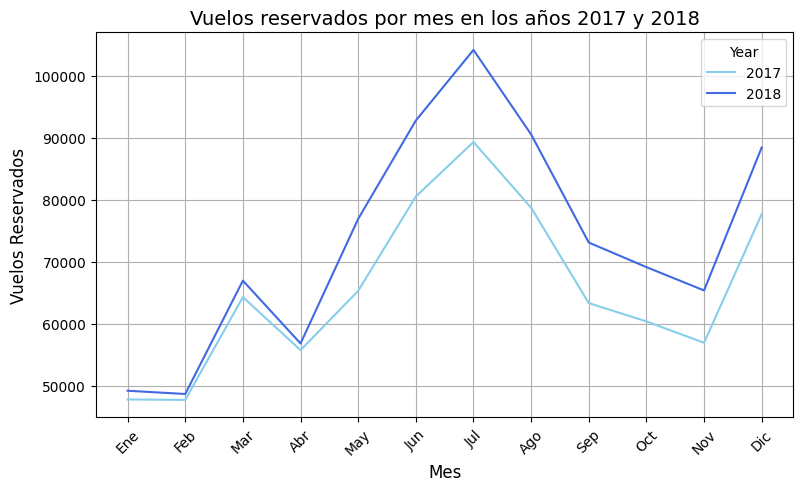

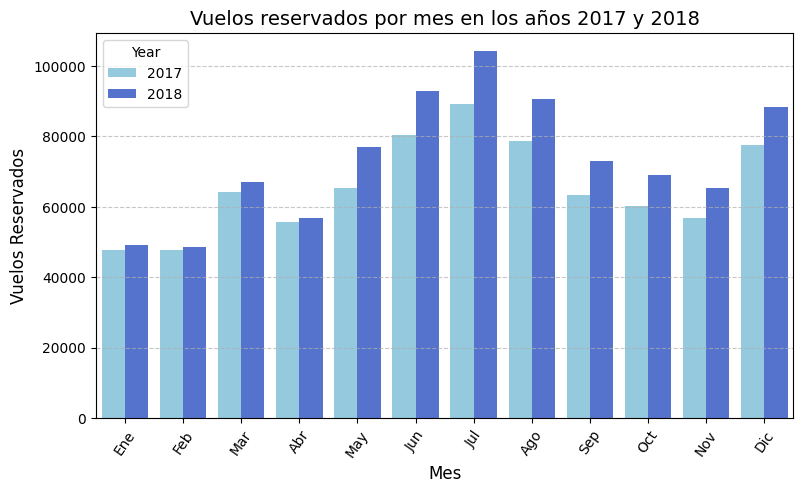

In [91]:
# 2.1 - Distribución de la cantidad de vuelos reservados por mes durante cada año

# Crear un DataFrame con la cantidad total de vuelos reservados por mes y año
df_year_month = df_merged.groupby(["Year", "Month"])["Flights Booked"].sum().reset_index()

# Ordenamos los meses correctamente para evitar errores de visualización
df_year_month["Month"] = pd.Categorical(df_year_month["Month"], categories=range(1, 13), ordered=True)

# Ordenamos los datos por año y mes para garantizar la secuencia correcta
df_year_month_sorted = df_year_month.sort_values(by=["Year", "Month"])

# Configuración del gráfico de líneas
plt.figure(figsize=(9, 5))
sns.lineplot(x="Month", 
             y="Flights Booked", 
             hue="Year",  # Diferenciar por año
             palette=["#87CEEB", "#4169E1"], 
             data=df_year_month)

# Personalización del gráfico
plt.title("Vuelos reservados por mes en los años 2017 y 2018", fontsize=14)
plt.xticks(ticks=range(1, 13), labels=["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], rotation=45)
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Vuelos Reservados", fontsize=12)
plt.grid(True)

plt.show()

# Configuración del gráfico de barras
plt.figure(figsize=(9, 5))

# Ordenar correctamente los datos para asegurar la alineación correcta
df_year_month_sorted = df_year_month.sort_values(by=["Month"])

# Crear gráfico de barras asegurando que los meses aparecen en orden correcto
sns.barplot(x="Month", 
            y="Flights Booked", 
            hue="Year",  
            data=df_year_month_sorted, 
            palette=["#87CEEB", "#4169E1"],  
            estimator=sum)

# Personalización del gráfico
plt.title("Vuelos reservados por mes en los años 2017 y 2018", fontsize=14)
plt.xticks(ticks=range(12), labels=["Ene", "Feb", "Mar", "Abr", "May", "Jun", "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"], rotation=55)
plt.xlabel("Mes", fontsize=12)
plt.ylabel("Vuelos Reservados", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

📊  Justificación del uso de gráficos:
	•	Línea → Se utiliza para visualizar la tendencia de vuelos reservados a lo largo del tiempo, ya que permite identificar aumentos y caídas en la demanda de forma clara.
	•	Barras → Se usa para comparar de manera más intuitiva la cantidad de vuelos por mes en cada año, ayudando a ver diferencias absolutas.

🔍 	Tendencia estacional:
	•	Hay un pico en los meses de mayo a julio, lo que indica que estos meses tienen una mayor demanda de vuelos.
	•	Tras este pico, la cantidad de vuelos disminuye en los meses siguientes, especialmente en septiembre y octubre.
	Comparación entre años:
	•	2018 muestra un incremento general en la cantidad de vuelos reservados en comparación con 2017.
	•	Sin embargo, la tendencia sigue un patrón similar en ambos años, lo que sugiere una estacionalidad en la demanda.

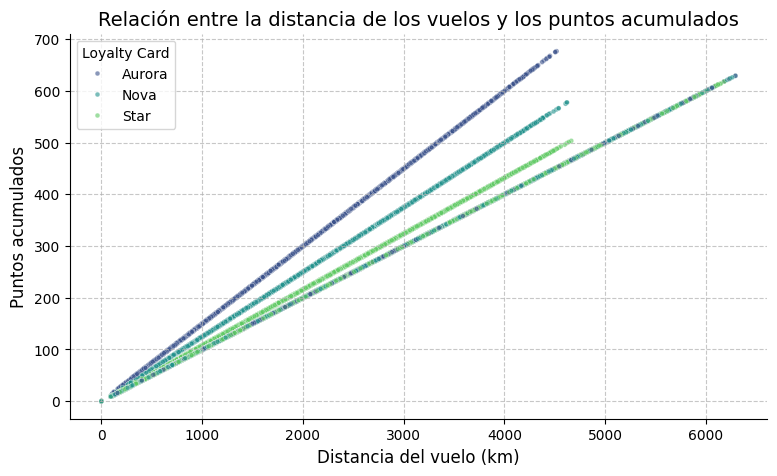

In [93]:
# 2.2 - Relación entre la distancia de los vuelos y los puntos acumulados

# Configuración del gráfico de dispersión
plt.figure(figsize=(9, 5))

sns.scatterplot(x="Distance", 
                y="Points Accumulated", 
                hue="Loyalty Card",  # Diferenciar por tipo de tarjeta de fidelidad
                data=df_merged, 
                s=12,  # Tamaño de los puntos
                alpha=0.6,  # Transparencia para mejorar la visualización
                palette="viridis")  # Paleta de colores

# Ajustes visuales
plt.title("Relación entre la distancia de los vuelos y los puntos acumulados", fontsize=14)
plt.xlabel("Distancia del vuelo (km)", fontsize=12)
plt.ylabel("Puntos acumulados", fontsize=12)

# Eliminamos los bordes superior y derecho del gráfico para hacerlo más limpio
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["top"].set_visible(False)

plt.grid(True, linestyle="--", alpha=0.7)  # Agregar líneas de referencia

plt.show()

📊  Se utiliza un scatterplot porque queremos analizar la relación entre dos variables numéricas: la distancia recorrida y los puntos acumulados. Este tipo de gráfico nos permite visualizar si hay una tendencia clara entre ambas variables y detectar posibles valores atípicos.

🔍 Sí, existe una relación positiva entre la distancia de los vuelos y los puntos acumulados. Se observa que, en general, a mayor distancia del vuelo, mayor es la cantidad de puntos acumulados por los clientes. Esto sugiere que el sistema de acumulación de puntos está basado en la distancia recorrida


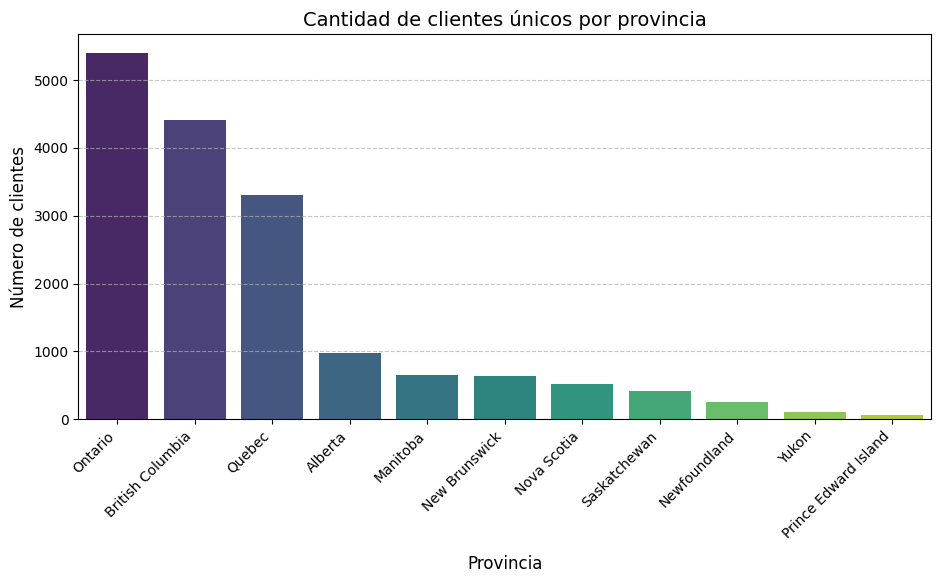

In [107]:
# 2.3 - Distribución de clientes por provincia

# Eliminamos duplicados para contar clientes únicos
df_unique_clients = df_merged.drop_duplicates(subset="Loyalty Number")

# Contamos la cantidad de clientes únicos por provincia y ordenamos de mayor a menor
clientes_por_provincia = df_unique_clients["Province"].value_counts().sort_values(ascending=False)

# Visualización de la distribución de clientes por provincia
plt.figure(figsize=(11, 5))
sns.barplot(x=clientes_por_provincia.index, 
            y=clientes_por_provincia.values, 
            hue=clientes_por_provincia.index,
            palette="viridis")  # Se usa una paleta de colores con suficientes tonos

# Ajustes visuales
plt.title("Cantidad de clientes únicos por provincia", fontsize=14)
plt.xlabel("Provincia", fontsize=12, labelpad=10)  # Ajuste del padding del xlabel
plt.ylabel("Número de clientes", fontsize=12)

# Rotamos las etiquetas y las alineamos hacia la izquierda
plt.xticks(rotation=45, ha="right")  # Alinear etiquetas a la derecha para que se vean más a la izquierda
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

📊 	•	Permite comparar de manera clara y ordenada el número de clientes en cada provincia.
	•	Es ideal para variables categóricas, como provincias, en lugar de gráficos de dispersión o circulares que no serían tan efectivos en este caso.

🔍 	•	Ontario es la provincia con mayor cantidad de clientes, seguida de Quebec y British Columbia.
	•	La provincia con menos clientes es Prince Edward Island.
	•	En general, las provincias más pobladas y con mayor actividad económica tienen más clientes en el programa de fidelización.

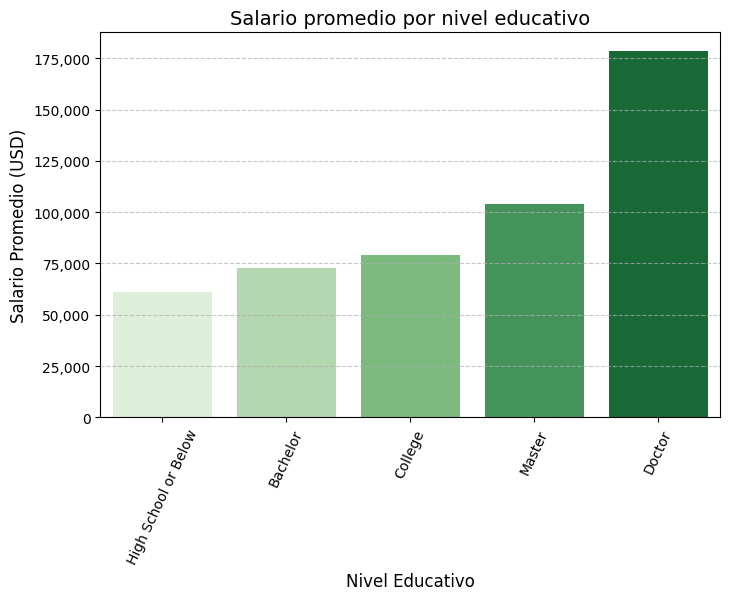

In [101]:
# 2.4 - Comparación del salario promedio por nivel educativo

# Eliminamos duplicados para no contar a la misma persona varias veces
df_unique_clients = df_merged.drop_duplicates(subset="Loyalty Number")

# Calculamos el salario promedio por nivel educativo
salario_por_educacion = df_unique_clients.groupby("Education")["Salary"].mean().sort_values()

# Visualización de la comparación de salario promedio por nivel educativo
plt.figure(figsize=(8, 5))
sns.barplot(x=salario_por_educacion.index, 
            y=salario_por_educacion.values, 
            hue=salario_por_educacion.index,  
            palette="Greens")  # Paleta predefinida que se adapta a cualquier cantidad de categorías

# Ajustes visuales
plt.title("Salario promedio por nivel educativo", fontsize=14)
plt.xlabel("Nivel Educativo", fontsize=12)
plt.ylabel("Salario Promedio (USD)", fontsize=12)
plt.xticks(rotation=65)  # Rotamos etiquetas para mejor visibilidad
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Formatear los valores del eje Y sin decimales
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.show()

📊  •   barplot porque es ideal para comparar valores categóricos.
	•	Seaborn barplot permite visualizar fácilmente cómo varía el salario promedio según la educación.
	•	Ordenamos los niveles educativos de menor a mayor salario para facilitar la interpretación.
	•	Se usó la paleta “Greens” para mantener la coherencia de colores con los gráficos anteriores.

🔍  •	Se observa que, a medida que aumenta el nivel educativo, también aumenta el salario promedio de los clientes.
	•	Existen diferencias salariales significativas entre distintos niveles de educación.
	•	Esto sugiere que la educación juega un papel clave en la capacidad adquisitiva de los clientes, lo que puede influir en sus decisiones de viaje.

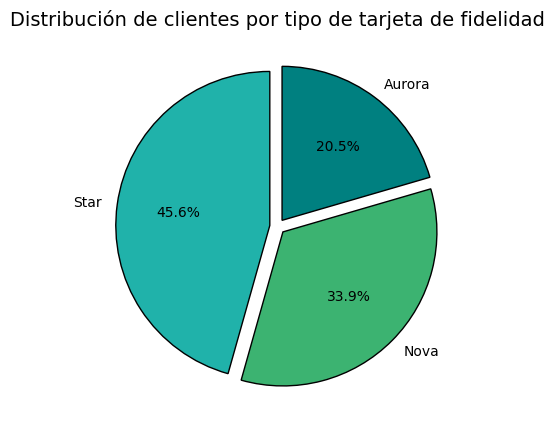

In [104]:
# 2.5 - Porcentaje de clientes por tipo de tarjeta de fidelidad

# Eliminamos duplicados para contar cada cliente solo una vez
df_unique_clients = df_merged.drop_duplicates(subset="Loyalty Number")

# Calculamos el porcentaje de clientes por tipo de tarjeta
clientes_por_tarjeta = df_unique_clients["Loyalty Card"].value_counts(normalize=True) * 100

# Definimos colores personalizados
colores = ["lightseagreen", "mediumseagreen", "teal", "turquoise"]

# Definimos el "explode" para separar ligeramente las secciones
explode = [0.05] * len(clientes_por_tarjeta)

# Creación del gráfico Pie
plt.figure(figsize=(5, 5))
plt.pie(clientes_por_tarjeta, 
        labels=clientes_por_tarjeta.index, 
        autopct="%1.1f%%", 
        colors=colores, 
        startangle=90, 
        wedgeprops={"edgecolor": "black", "linewidth": 1}, 
        explode=explode)  # Separación de las secciones

# Ajustes visuales
plt.title("Distribución de clientes por tipo de tarjeta de fidelidad", fontsize=14)
plt.show()

📊  •   Este gráfico permite comparar claramente qué tipos de tarjeta son más populares entre los clientes.
    •   Al usar porcentajes en lugar de valores absolutos, podemos evaluar la distribución relativa de los clientes.

🔍 	•	La mayoría de los clientes usan la tarjeta Star, lo que sugiere que es la opción más accesible o con mejores beneficios.
	•	Aurora y Nova tienen una proporción menor de clientes, lo que podría indicar que están dirigidas a segmentos más específicos o con requisitos diferentes.

In [106]:
# Calculamos el porcentaje de clientes por tipo de tarjeta
clientes_por_tarjeta = df_unique_clients["Loyalty Card"].value_counts(normalize=True) * 100

# Mostramos los valores en consola
print("\n📊 Porcentaje de clientes por cada tipo de tarjeta de fidelidad:")
print(clientes_por_tarjeta.round(2).astype(str) + "%")  # Redondeamos a 2 decimales y agregamos "%"


📊 Porcentaje de clientes por cada tipo de tarjeta de fidelidad:
Loyalty Card
Star      45.63%
Nova      33.88%
Aurora    20.49%
Name: proportion, dtype: object


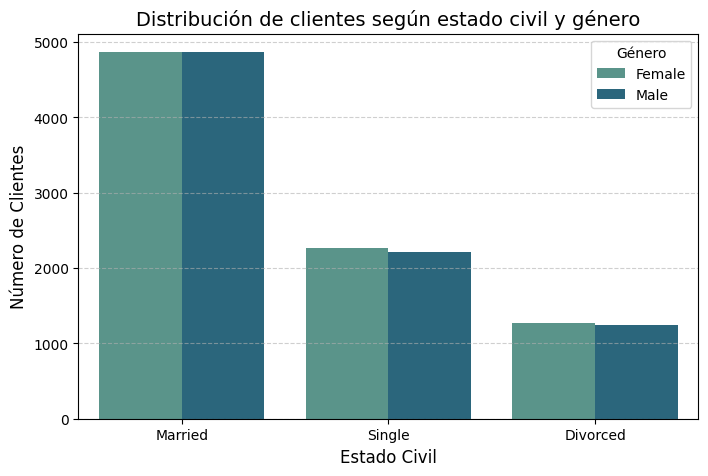

In [108]:
# 2.6 - Distribución de clientes según estado civil y género

# Eliminamos duplicados para no contar a la misma persona varias veces
df_unique_clients = df_merged.drop_duplicates(subset="Loyalty Number")

# Visualización de la distribución de clientes según estado civil y género
plt.figure(figsize=(8, 5))
sns.countplot(x="Marital Status", hue="Gender", data=df_unique_clients, palette="crest", dodge=True)

# Ajustes visuales
plt.title("Distribución de clientes según estado civil y género", fontsize=14)
plt.xlabel("Estado Civil", fontsize=12)
plt.ylabel("Número de Clientes", fontsize=12)
plt.xticks(rotation=0)  # Mantener etiquetas rectas para este tipo de gráfico
plt.legend(title="Género")
plt.grid(axis="y", linestyle="--", alpha=0.6)  # Grid en el eje Y para facilitar la lectura

plt.show()

📊  •  Este gráfico de barras (countplot) muestra la distribución de clientes según su estado civil, diferenciando entre hombres y mujeres con hue="Gender".

🔍 	La distribución de clientes según su estado civil y género muestra que:
		El grupo más numeroso corresponde a clientes casados (Married), seguido de los solteros (Single). En todas las categorías, la cantidad de hombres y mujeres es relativamente equilibrada, aunque pueden existir pequeñas diferencias según el estado civil.
		Los clientes divorciados y viudos representan una menor proporción en comparación con los otros grupos.

In [109]:
# Contar la cantidad de clientes por estado civil y género
estado_civil_genero = df_unique_clients.groupby(["Marital Status", "Gender"])["Loyalty Number"].count()

# Mostrar los datos específicamente para "Married"
print(estado_civil_genero.loc["Married"])

Gender
Female    4869
Male      4866
Name: Loyalty Number, dtype: int64


In [110]:
print(df_unique_clients["Marital Status"].value_counts())

Marital Status
Married     9735
Single      4484
Divorced    2518
Name: count, dtype: int64


In [114]:
# Creación del DataFrame final limpio
df_final = df_merged.dropna().drop_duplicates(subset="Loyalty Number")

# Resumen del DataFrame final
print("\n Resumen del DataFrame final limpio:")
df_final.info()

# Verificación de valores nulos
nulos_totales = df_final.isnull().sum().sum()
print(f"\n Valores nulos en el DataFrame final: {nulos_totales} (debe ser 0)")

# Verificación de clientes únicos
print(f"\n Cantidad de clientes únicos en el DataFrame final: {len(df_final)}")

# Guardar el DataFrame final en un archivo CSV
df_final.to_csv("df_final.csv", index=False)


 Resumen del DataFrame final limpio:
<class 'pandas.core.frame.DataFrame'>
Index: 16737 entries, 0 to 403505
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Loyalty Number               16737 non-null  int64         
 1   Year                         16737 non-null  int64         
 2   Month                        16737 non-null  int64         
 3   Flights Booked               16737 non-null  int64         
 4   Flights with Companions      16737 non-null  int64         
 5   Total Flights                16737 non-null  int64         
 6   Distance                     16737 non-null  int64         
 7   Points Accumulated           16737 non-null  float64       
 8   Points Redeemed              16737 non-null  int64         
 9   Dollar Cost Points Redeemed  16737 non-null  int64         
 10  Country                      16737 non-null  object        
 11  Provinc

In [115]:
import os
print("df_final.csv" in os.listdir())  # Debe devolver True si el archivo existe

True


In [ ]:
## Fase 3: Evaluación de Diferencias en Reservas de Vuelos por Nivel Educativo

In [ ]:
# 3.1 - Preparación de Datos - 	Objetivo: Filtrar únicamente las columnas necesarias para el análisis (‘Flights Booked’ y ‘Education’).

# Filtramos el DataFrame con solo las columnas necesarias
df_education_flights = df_final[["Flights Booked", "Education"]].copy()

# Eliminamos posibles valores nulos en estas columnas
df_education_flights.dropna(inplace=True)

# Mostramos las primeras filas para verificar los datos
df_education_flights.head()

In [ ]:
# 3.2 - Análisis Descriptivo - Obtener estadísticas básicas (media, desviación estándar, etc.) para cada nivel educativo.

# Agrupamos por nivel educativo y calculamos estadísticas descriptivas
stats_education = df_education_flights.groupby("Education")["Flights Booked"].agg(["mean", "std", "count"]).round(2)

#por concluir-------------